# Setup

## Imports

In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from typing import List

In [404]:
plt.rcParams["font.family"] ="NanumGothic"
plt.rcParams["axes.unicode_minus"] =False

In [405]:
# Logger config
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [406]:
train_df = pd.read_csv("./input/processed/train_df_imputed.csv")
test_df = pd.read_csv("./input/processed/test_df_imputed.csv")
station_info_processed = pd.read_csv("./input/processed/station_info_processed.csv")

In [407]:
train_df.head()

,id,station,station_name,date,cloud_cover_0,cloud_cover_1,cloud_cover_10,cloud_cover_11,cloud_cover_12,cloud_cover_13,...,wind_speed_23,wind_speed_3,wind_speed_4,wind_speed_5,wind_speed_6,wind_speed_7,wind_speed_8,wind_speed_9,climatology_temp,target
0,0,98,동두천,01-01,0.0,0.0,9.0,0.0,3.0,3.0,...,2.3,0.6,0.3,0.7,0.6,0.7,0.8,0.1,-2.707143,-3.992857
1,1,98,동두천,01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7,0.2,0.0,1.1,1.3,0.5,0.9,0.4,-3.646429,-1.653571
2,2,98,동두천,01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,1.5,0.8,0.8,0.9,1.0,1.1,0.1,-2.694643,-0.005357
3,3,98,동두천,01-04,0.0,0.0,2.0,0.0,0.0,1.0,...,0.9,0.3,0.5,0.2,0.5,1.3,0.5,0.2,-2.501786,-0.898214
4,4,98,동두천,01-05,0.0,0.0,0.0,0.0,0.0,0.0,...,1.4,1.1,1.6,1.4,1.8,0.5,1.1,0.6,-2.625000,-1.775000


## Helper Functions

In [408]:
def pipe(df, func, *args, **kwargs):
    """Allows df.pipe(func, *args, **kwargs) for our custom funcs."""
    return func(df, *args, **kwargs)

In [409]:
def extract_time_feature_bases(df: pd.DataFrame) -> List[str]:
    time_cols = [col for col in df.columns if re.match(r".+_\d{1,2}$", col)]
    return sorted({col.rsplit("_", 1)[0] for col in time_cols})


In [410]:
def check_nan(df: pd.DataFrame) -> int:
    return df.isna().sum().sum()

# Feature Engineering

In [411]:
def merge_with_station_data(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    output = output.merge(station_df, on='station', how='left')
    output = output.drop(columns=['station', 'station_name'])

    return output

In [412]:
def date_column_handler(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    # Convert string to datetime(with consideration of leap years, making them all to be in 2024) for future use
    if df['date'].dtype == object:
        output['date'] = pd.to_datetime('2024-' + df['date'], format='%Y-%m-%d', errors='coerce')

    # Note)
    # Model might falsely interpret the valuse as ordinal or linear(i.e., it may think Febulary is "twice as big" as Jan!)
    # So we are converting them into sin/cos
    # +) considering our target: the next day's temperature anomaly, therefore we would better to use sin/cos for day of year(doy)!
    # We use both sin/cos -> since we want to uniquely represent any position on a cycle! therefore we need 2D coords

    doy = output['date'].dt.dayofyear
    # Dataset is including the leap year -> so we use the average year length(if other better ideas, please post them at the PR!!)
    output['doy_sin'] = np.sin(2 * np.pi * doy / 365)
    output['doy_cos'] = np.cos(2 * np.pi * doy / 365)

    # solar declination δ (radians)
    δ = np.deg2rad(23.44) * np.sin(2 * np.pi * (doy - 81) / 365.0)
    φ = np.deg2rad(output['lat'].values)
    # hour angle at sunrise ω₀ = arccos(−tanφ⋅tanδ)
    ω0 = np.arccos(-np.tan(φ) * np.tan(δ))
    # day length in hours = 2·ω₀·(180/π)/15
    day_len = 2 * ω0 * (180.0/np.pi) / 15.0
    output['day_length'] = day_len

    output = output.drop(columns=['date', 'lat'])

    return output

In [413]:
def engineer_dew_humidity_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    dew_cols = [f'dew_point_{h}' for h in range(24)]
    hum_cols = [f'humidity_{h}'  for h in range(24)]
    if set(dew_cols).issubset(output.columns) and set(hum_cols).issubset(output.columns):
        output['dew_point_avg'] = output[dew_cols].mean(axis=1)
        output['humidity_avg'] = output[hum_cols].mean(axis=1)
        output['dew_humidity_interaction'] = output['dew_point_avg'] * output['humidity_avg']
    return output

In [414]:
def engineer_surface_temp_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    st_cols = [f"surface_temp_{i}" for i in range(24)]
    dp_cols = [f"dew_point_{i}"   for i in range(24)]
    if not (set(st_cols) <= set(output.columns) and set(dp_cols) <= set(output.columns)):
        return output

    arr_t  = output[st_cols].values
    arr_dp = output[dp_cols].values

    output["surface_temp_avg"] = arr_t.mean(axis=1)
    if "climatology_temp" in output.columns:
        output["surface_temp_anomaly"] = (
            output["surface_temp_avg"] - output["climatology_temp"]
        )

    periods = {
        "night": slice(0,  6),
        "morning": slice(6, 12),
        "afternoon": slice(12,18),
        "evening": slice(18,24),
    }
    for name, sl in periods.items():
        t = arr_t[:, sl].mean(axis=1)
        d = arr_dp[:, sl].mean(axis=1)
        output[f"temp_{name}_avg"] = t
        output[f"dp_{name}_avg"] = d
        output[f"dew_depression_{name}"] = t - d
        output[f"temp_dp_interaction_{name}"] = t * d

    return output

In [415]:
def engineer_pressure_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    slp_cols = [f'sea_level_pressure_{h}' for h in range(24)]
    if set(slp_cols).issubset(output.columns):
        output['pressure_tendency'] = output[slp_cols[-1]] - output[slp_cols[0]]
        output['slp_avg'] = output[slp_cols].mean(axis=1)
    return output

In [416]:
def engineer_wind_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    wind_spd_cols = [f'wind_speed_{h}' for h in range(24)]
    wind_dir_cols = [f'wind_direction_{h}' for h in range(24)]

    if set(wind_spd_cols).issubset(output.columns):
        output['wind_speed_avg'] = output[wind_spd_cols].mean(axis=1)

    # if set(wind_dir_cols).issubset(output.columns):
    #     output['wind_direction_avg'] = output[wind_dir_cols].mean(axis=1)

    return output

In [417]:
def engineer_cloud_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    min_cloud_h_cols = [f'min_cloud_height_{h}' for h in range(24)]
    cloud_cover_cols = [f'cloud_cover_{h}' for h in range(24)]

    if set(min_cloud_h_cols).issubset(output.columns):
        output['min_cloud_h_avg'] = output[min_cloud_h_cols].mean(axis=1)

    if set(cloud_cover_cols).issubset(output.columns):
        output['cloud_cover_avg'] = output[cloud_cover_cols].mean(axis=1)

    return output

In [418]:
def engineer_percip_features(df: pd.DataFrame) -> pd.DataFrame:
    output_df = df.copy()
    rain_threshold = 0.01
    hourly_precip_cols = [f'precipitation_{h}' for h in range(24)]
    epsilon = 1e-6 # For safe division if alternative methods to np.divide are needed

    # Check if all required precipitation columns exist
    # If this 'if' statement violates an absolute "no if statements" rule for all feature engineering,
    # you would remove this block and ensure upstream that these columns always exist.
    # However, for a utility function, this check is good practice.
    if not set(hourly_precip_cols).issubset(output_df.columns):
        print("Warning: Not all 24 hourly precipitation columns (precipitation_0 to precipitation_23) found. "
              "Skipping precipitation feature engineering.")
        return output_df # Return original df if columns are missing

    # Ensure data is numeric before operations
    precip_data = output_df[hourly_precip_cols].astype(float)

    # --- Basic Aggregations ---
    output_df['precip_total_24hr'] = precip_data.sum(axis=1)
    output_df['precip_avg_24hr'] = precip_data.mean(axis=1) # Original feature
    output_df['precip_max_hourly'] = precip_data.max(axis=1)
    output_df['precip_std_dev_24hr'] = precip_data.std(axis=1)
    # Note: .std() on a row of constant values (e.g., all zeros) will correctly produce 0.

    # --- Event-Based Features ---
    # Number of hours with precipitation above the defined threshold
    raining_hours_series = (precip_data > rain_threshold).sum(axis=1)
    output_df['precip_hours_raining'] = raining_hours_series

    # Boolean flag: any precipitation total above a minimal threshold during the 24 hours?
    # Using precip_total_24hr > 0 (or small threshold) is often more robust than relying on sum of flags
    output_df['precip_is_raining_flag'] = (output_df['precip_total_24hr'] > rain_threshold).astype(int)

    # Average precipitation intensity *during raining hours only*
    # np.divide handles division by zero by outputting a specified value (here, 0)
    output_df['precip_intensity_avg_if_raining'] = np.divide(
        output_df['precip_total_24hr'],
        raining_hours_series,
        out=np.zeros_like(output_df['precip_total_24hr'], dtype=float), # Ensure float output
        where=(raining_hours_series != 0)
    )

    output_df['precip_dry_hours_24hr'] = 24 - output_df['precip_hours_raining']

    # Contribution of the max hourly precipitation to the total 24hr precipitation
    # This indicates if rain was concentrated or spread out.
    output_df['precip_contribution_max_hour'] = np.divide(
        output_df['precip_max_hourly'],
        output_df['precip_total_24hr'],
        out=np.zeros_like(output_df['precip_max_hourly'], dtype=float), # If total is 0, max is 0, ratio is 0
        where=(output_df['precip_total_24hr'] > 0) # Avoids division by zero for dry days
    )
    # Ensure it's exactly 0 where total is 0, as np.divide might leave small residuals depending on 'out'
    output_df.loc[output_df['precip_total_24hr'] == 0, 'precip_contribution_max_hour'] = 0.0


    # --- More advanced features (examples, can be expanded) ---
    # Number of distinct precipitation periods (e.g., separated by at least one dry hour)
    # This is more complex and typically involves iterating or using groupby-like logic if vectorized.
    # For simplicity and adhering to typical "no if-loops" in basic feature engineering, this is omitted here
    # but could be a separate, more advanced function.

    # Example: Was precipitation primarily in the first 12hrs vs last 12hrs?
    # output_df['precip_first_12hr_total'] = precip_data[[f'precipitation_{h}' for h in range(12)]].sum(axis=1)
    # output_df['precip_last_12hr_total'] = precip_data[[f'precipitation_{h}' for h in range(12, 24)]].sum(axis=1)
    # output_df['precip_morning_bias_ratio'] = (output_df['precip_first_12hr_total'] + epsilon) / \
    #                                          (output_df['precip_last_12hr_total'] + output_df['precip_first_12hr_total'] + 2*epsilon)


    return output_df

In [419]:
def engineer_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    epsilon = 1e-6

    # --- Part 1: Foundational Components & Essential Transformations ---
    # (Based on the R² 0.8186 successful set)
    output['temp_evening_minus_night_avg'] = output['temp_evening_avg'] - output['temp_night_avg'] # TEMNA
    output['dew_depression_change_day_progress'] = output['dew_depression_afternoon'] - output['dew_depression_morning'] # dew_change_day

    output['log_elev'] = np.log(output['elev'] + epsilon)
    output['elev_sq'] = output['elev'] ** 2
    output['log_slp_avg'] = np.log(output['slp_avg'] + epsilon)
    output['signed_sqrt_temp_evening_minus_night_avg'] = np.sign(output['temp_evening_minus_night_avg']) * np.sqrt(np.abs(output['temp_evening_minus_night_avg']))
    output['signed_sqrt_STA'] = np.sign(output['surface_temp_anomaly']) * np.sqrt(np.abs(output['surface_temp_anomaly']))
    output['log_min_cloud_h_avg'] = np.log(output['min_cloud_h_avg'] + epsilon)
    output['doy_cos_sq'] = output['doy_cos'] ** 2
    output['pressure_tendency_sq'] = output['pressure_tendency'] ** 2
    output['sqrt_humidity_avg'] = np.sqrt(output['humidity_avg'] + epsilon)

    output['STA_x_slp_avg'] = output['surface_temp_anomaly'] * output['slp_avg']
    output['dp_evening_avg_X_humidity_avg'] = output['dp_evening_avg'] * output['humidity_avg'] # dp_eve_hum
    output['humidity_avg_x_dew_depression_morning'] = output['humidity_avg'] * output['dew_depression_morning'] # HumDewMorn
    output['humidity_avg_x_dew_depression_evening'] = output['humidity_avg'] * output['dew_depression_evening'] # HumDewEve
    output['hum_dew_morn_X_hum_dew_eve'] = output['humidity_avg_x_dew_depression_morning'] * output['humidity_avg_x_dew_depression_evening'] # HDM_X_HDE
    output['climatology_temp_x_doy_cos'] = output['climatology_temp'] * output['doy_cos']
    output['climatology_temp_x_doy_sin'] = output['climatology_temp'] * output['doy_sin']
    output['seasonal_pressure_tendency_sin'] = output['pressure_tendency'] * output['doy_sin'] # spts
    output['seasonal_pressure_tendency_cos'] = output['pressure_tendency'] * output['doy_cos'] # sptc
    output['humidity_avg_x_dew_depression_morning_sq'] = output['humidity_avg_x_dew_depression_morning']**2
    output['dp_eve_hum_sq'] = output['dp_evening_avg_X_humidity_avg'] ** 2

    # --- Part 2: Constructing Top Performing Features ---
    output['ratio_STA_slp_div_wind_speed'] = output['STA_x_slp_avg'] / (output['wind_speed_avg'] + epsilon) # R_STA_slp_wind
    output['ratio_log_min_cloud_STA_div_wind_speed'] = (output['log_min_cloud_h_avg'] * output['surface_temp_anomaly']) / (output['wind_speed_avg'] + epsilon) # R_LMC_STA_WIND
    output['ratio_STA_x_slp_div_humidity_avg'] = output['STA_x_slp_avg'] / (output['humidity_avg'] + epsilon) # R_STA_slp_hum

    output['ratio_STA_elev_div_humidity_avg'] = (output['surface_temp_anomaly'] * output['elev']) / (output['humidity_avg'] + epsilon)
    output['ratio_STA_slp_div_cloud_cover_avg'] = output['STA_x_slp_avg'] / (output['cloud_cover_avg'] + epsilon)

    output['ratio_STA_slp_wind_X_elev'] = output['ratio_STA_slp_div_wind_speed'] * output['elev']
    output['ratio_STA_slp_hum_X_log_elev'] = output['ratio_STA_x_slp_div_humidity_avg'] * output['log_elev']
    output['ratio_dp_eve_hum_div_slp_avg'] = output['dp_evening_avg_X_humidity_avg'] / (output['slp_avg'] + epsilon)
    output['ratio_hum_dew_eve_div_slp_avg'] = output['humidity_avg_x_dew_depression_evening'] / (output['slp_avg'] + epsilon)
    output['ratio_STA_slp_hum_X_signed_sqrt_TEMNA'] = output['ratio_STA_x_slp_div_humidity_avg'] * output['signed_sqrt_temp_evening_minus_night_avg']
    output['ratio_slp_TEMNA_div_humidity_avg'] = (output['slp_avg'] * output['temp_evening_minus_night_avg']) / (output['humidity_avg'] + epsilon)
    output['ratio_log_min_cloud_STA_div_slp_avg'] = (output['log_min_cloud_h_avg'] * output['surface_temp_anomaly']) / (output['slp_avg'] + epsilon)
    output['ratio_log_min_cloud_STA_div_cloud_cover_avg'] = (output['log_min_cloud_h_avg'] * output['surface_temp_anomaly']) / (output['cloud_cover_avg'] + epsilon)

    output['log_slp_avg_X_dp_eve_hum'] = output['log_slp_avg'] * output['dp_evening_avg_X_humidity_avg'] # LSDH
    output['log_min_cloud_h_avg_X_STA'] = output['log_min_cloud_h_avg'] * output['surface_temp_anomaly']
    output['signed_sqrt_STA_X_slp_avg'] = output['signed_sqrt_STA'] * output['slp_avg']
    output['signed_sqrt_TEMNA_X_doy_cos'] = output['signed_sqrt_temp_evening_minus_night_avg'] * output['doy_cos']
    output['ss_TEMNA_doy_cos_X_ratio_STA_slp_wind'] = output['signed_sqrt_TEMNA_X_doy_cos'] * output['ratio_STA_slp_div_wind_speed']
    output['log_elev_X_STA'] = output['log_elev'] * output['surface_temp_anomaly']
    output['signed_sqrt_STA_X_log_elev'] = output['signed_sqrt_STA'] * output['log_elev']
    output['log_elev_X_TEMNA'] = output['log_elev'] * output['temp_evening_minus_night_avg']

    output['HDM_X_HDE_X_slp_avg'] = output['hum_dew_morn_X_hum_dew_eve'] * output['slp_avg']
    output['HDM_X_HDE_X_STA'] = output['hum_dew_morn_X_hum_dew_eve'] * output['surface_temp_anomaly']
    output['HDM_X_HDE_X_log_elev'] = output['hum_dew_morn_X_hum_dew_eve'] * output['log_elev']
    output['HDM_X_HDE_X_cloud_cover_avg'] = output['hum_dew_morn_X_hum_dew_eve'] * output['cloud_cover_avg']
    output['dp_eve_hum_X_hum_dew_eve'] = output['dp_evening_avg_X_humidity_avg'] * output['humidity_avg_x_dew_depression_evening']
    output['STA_slp_X_hum_dew_eve'] = output['STA_x_slp_avg'] * output['humidity_avg_x_dew_depression_evening']
    output['STA_slp_X_clim_temp'] = output['STA_x_slp_avg'] * output['climatology_temp']
    output['sta_X_doy_cos'] = output['surface_temp_anomaly'] * output['doy_cos']
    output['dp_eve_hum_X_doy_cos'] = output['dp_evening_avg_X_humidity_avg'] * output['doy_cos']
    output['clim_doy_sin_slp_X_doy_cos_sq'] = output['climatology_temp_x_doy_sin'] * output['slp_avg'] * output['doy_cos_sq']
    output['log_slp_avg_X_sqrt_humidity_avg'] = output['log_slp_avg'] * output['sqrt_humidity_avg']
    output['log_slp_avg_X_doy_sin'] = output['log_slp_avg'] * output['doy_sin']
    output['log_slp_avg_X_doy_cos'] = output['log_slp_avg'] * output['doy_cos']

    output['pressure_tendency_sq_X_clim_doy_cos'] = output['pressure_tendency_sq'] * output['climatology_temp_x_doy_cos']
    output['dew_change_day_X_humidity_avg'] = output['dew_depression_change_day_progress'] * output['humidity_avg'] # DCD_Hum
    output['clim_doy_cos_X_slp_avg_base'] = output['climatology_temp_x_doy_cos'] * output['slp_avg']
    output['clim_doy_cos_slp_X_doy_sin_sq'] = output['clim_doy_cos_X_slp_avg_base'] * output['doy_sin'] * output['doy_sin']
    output['dp_evening_avg_X_pressure_tendency'] = output['dp_evening_avg'] * output['pressure_tendency']

    # --- Part 3: (Placeholder for features pruned from earlier iterations) ---

    # --- Part 4: Targeted Features (Based on R² 0.8186 set + one new "New Perspective" interaction) ---

    # Features from R² 0.8186 baseline Part 4:
    output['DCD_Hum_X_log_elev'] = output['dew_change_day_X_humidity_avg'] * output['log_elev']
    output['LMC_X_ratio_STA_elev_div_hum'] = output['log_min_cloud_h_avg'] * output['ratio_STA_elev_div_humidity_avg']
    output['ratio_TEMNA_div_wind'] = output['temp_evening_minus_night_avg'] / (output['wind_speed_avg'] + epsilon)
    output['R_LMC_STA_WIND_X_elev_sq'] = output['ratio_log_min_cloud_STA_div_wind_speed'] * output['elev_sq']

    if 'precip_contribution_max_hour' in output.columns and 'elev_sq' in output.columns:
        output['precip_contrib_max_hr_X_elev_sq'] = output['precip_contribution_max_hour'] * output['elev_sq']
    else:
        print("Warning: 'precip_contribution_max_hour' or 'elev_sq' not found for 'precip_contrib_max_hr_X_elev_sq'.")

    # New addition for this iteration ("New Perspective"):
    # Ensure 'day_length' (base feature) and 'R_LMC_STA_WIND_X_elev_sq' are present
    if 'R_LMC_STA_WIND_X_elev_sq' in output.columns and 'day_length' in output.columns:
        output['Top1_X_day_length'] = output['R_LMC_STA_WIND_X_elev_sq'] * output['day_length']
    else:
        print("Warning: 'R_LMC_STA_WIND_X_elev_sq' or 'day_length' not found for creating 'Top1_X_day_length'.")

    return output

In [420]:
def drop_unused_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    # Drop {prefix}_{n}(original) features
    prefixes = extract_time_feature_bases(output)
    drop_cols = [f"{p}_{h}" for p in prefixes for h in range(24)]
    existing = [col for col in drop_cols if col in df.columns]

    output = output.drop(columns=existing)

    return output

In [421]:
def engineer_features(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    return (
        output
        .pipe(merge_with_station_data, station_df)
        .pipe(date_column_handler)
        .pipe(engineer_dew_humidity_features)
        .pipe(engineer_surface_temp_features)
        .pipe(engineer_pressure_features)
        .pipe(engineer_wind_features)
        .pipe(engineer_cloud_features)
        .pipe(engineer_percip_features)
        .pipe(engineer_interaction_features)
        .pipe(drop_unused_features)
    )

In [422]:
train_df = engineer_features(train_df, station_info_processed)
test_df = engineer_features(test_df, station_info_processed)

In [423]:
train_df.shape

(13132, 109)

In [424]:
test_df.shape

(3004, 108)

In [425]:
train_df

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,dew_point_avg,humidity_avg,dew_humidity_interaction,...,dew_change_day_X_humidity_avg,clim_doy_cos_X_slp_avg_base,clim_doy_cos_slp_X_doy_sin_sq,dp_evening_avg_X_pressure_tendency,DCD_Hum_X_log_elev,LMC_X_ratio_STA_elev_div_hum,ratio_TEMNA_div_wind,R_LMC_STA_WIND_X_elev_sq,precip_contrib_max_hr_X_elev_sq,Top1_X_day_length
0,0,-2.707143,-3.992857,115.62,1.721336e-02,0.999852,9.426812,-16.808333,46.875000,-787.890625,...,268.750000,-2799.887516,-8.296056e-01,32.648333,1276.645533,-31.003020,1.760390,-98597.507314,1548.416765,-9.294601e+05
1,1,-3.646429,-1.653571,115.62,3.442161e-02,0.999407,9.437325,-17.466667,45.500000,-794.733333,...,525.525000,-3772.333341,-4.469639e+00,-18.736667,2496.406116,-33.168857,3.082248,-181289.935304,1672.464844,-1.710892e+06
2,2,-2.694643,-0.005357,115.62,5.161967e-02,0.998667,9.448699,-17.645833,43.583333,-769.064236,...,584.743056,-2788.051558,-7.429014e+00,-7.420000,2777.710176,-43.021782,4.217817,-257573.492734,1672.555693,-2.433734e+06
3,3,-2.501786,-0.898214,115.62,6.880243e-02,0.997630,9.460926,-11.966667,53.166667,-636.227778,...,257.858333,-2575.183909,-1.219034e+01,48.720000,1224.906751,-13.217564,4.617882,-79268.297718,1517.375165,-7.499515e+05
4,4,-2.625000,-1.775000,115.62,8.596480e-02,0.996298,9.473997,-15.729167,40.583333,-638.342014,...,594.545833,-2688.314479,-1.986650e+01,-32.106667,2824.276399,-12.493280,-0.221574,-41017.953652,1734.218506,-3.886040e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,17506,-3.485714,0.785714,80.09,-6.880243e-02,0.997630,9.449241,-5.366667,63.500000,-340.783333,...,258.233333,-3565.491756,-1.687823e+01,-43.425000,1131.875697,14.418590,0.027273,39997.528232,768.311522,3.779463e+05
13128,17507,-2.632143,-0.367857,80.09,-5.161967e-02,0.998667,9.455193,-11.600000,52.333333,-607.066667,...,45.355556,-2701.293544,-7.197840e+00,30.940000,198.800249,11.979583,0.476190,40988.494802,870.767113,3.875541e+05
13129,17508,-1.555357,1.055357,80.09,-3.442161e-02,0.999407,9.462014,-11.720833,52.541667,-615.832118,...,-26.270833,-1594.170695,-1.888849e+00,-13.475000,-115.149030,1.692089,0.368421,5621.377367,884.553175,5.318955e+04
13130,17509,-2.814286,6.614286,80.09,-1.721336e-02,0.999852,9.469701,-5.958333,69.625000,-414.848958,...,80.068750,-2889.761132,-8.562352e-01,7.663333,350.953423,6.986201,2.131576,61510.823117,776.854512,5.824891e+05


In [426]:
test_df

,id,climatology_temp,elev,doy_sin,doy_cos,day_length,dew_point_avg,humidity_avg,dew_humidity_interaction,surface_temp_avg,...,dew_change_day_X_humidity_avg,clim_doy_cos_X_slp_avg_base,clim_doy_cos_slp_X_doy_sin_sq,dp_evening_avg_X_pressure_tendency,DCD_Hum_X_log_elev,LMC_X_ratio_STA_elev_div_hum,ratio_TEMNA_div_wind,R_LMC_STA_WIND_X_elev_sq,precip_contrib_max_hr_X_elev_sq,Top1_X_day_length
0,0,24.017857,39.81,-0.835925,-0.548843,12.946233,21.679167,77.416667,1678.328819,26.612500,...,149.672222,-13267.769898,-9271.138241,55.380000,551.410152,5.039332,-0.602272,10589.315606,1037.230130,137091.749099
1,1,1.778571,30.59,-0.523416,0.852078,9.580320,-5.075000,70.000000,-355.250000,0.387500,...,361.666667,1568.914059,429.825811,18.936667,1237.143471,-3.366737,5.695989,-13841.627355,125.748104,-132607.221327
2,2,24.091071,30.59,-0.111659,-0.993747,14.503336,22.141667,87.666667,1941.086111,27.279167,...,444.177778,-24119.374490,-300.713942,-55.161667,1519.387016,5.006981,8.719409,23183.853686,116.692666,336243.209487
3,3,27.076786,30.59,-0.693281,-0.720667,13.466553,25.683333,85.708333,2201.275694,33.554167,...,1148.491667,-19680.758261,-9459.337206,-4.940000,3928.614654,11.361901,2.818895,28146.903916,115.707977,379041.773551
4,4,7.417857,30.59,0.970064,0.242850,11.832631,-2.470833,60.916667,-150.514931,8.725000,...,1100.561111,1837.633179,1729.256948,-1.218333,3764.659888,4.045246,4.560506,5761.582638,116.983268,68174.679543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,2999,1.932143,39.81,-0.463550,0.886071,9.569618,-7.950000,44.291667,-352.118750,2.841667,...,300.445139,1765.772294,379.427126,27.466667,1106.875393,3.231523,-0.228288,3393.339676,187.403095,32472.963658
3000,3000,12.312500,30.59,0.999917,-0.012910,12.458907,-6.066667,53.791667,-326.336111,6.583333,...,788.944444,-162.604782,-162.577680,1.085000,2698.721110,-17.078588,2.543819,-15156.448265,130.031155,-188832.779411
3001,3001,27.073214,39.81,-0.393590,-0.919286,14.094582,18.466667,75.833333,1400.388889,21.850000,...,270.472222,-24846.338604,-3849.028452,11.710000,996.451626,-7.425515,0.960835,-7023.624033,269.759336,-98995.043470
3002,3002,18.208929,39.81,0.642055,-0.766659,14.182867,14.370833,74.958333,1077.213715,25.062500,...,1196.834722,-14216.144167,-5860.381597,10.511667,4409.280537,14.009300,2.270967,21576.779323,189.644967,306020.590344


<Axes: >

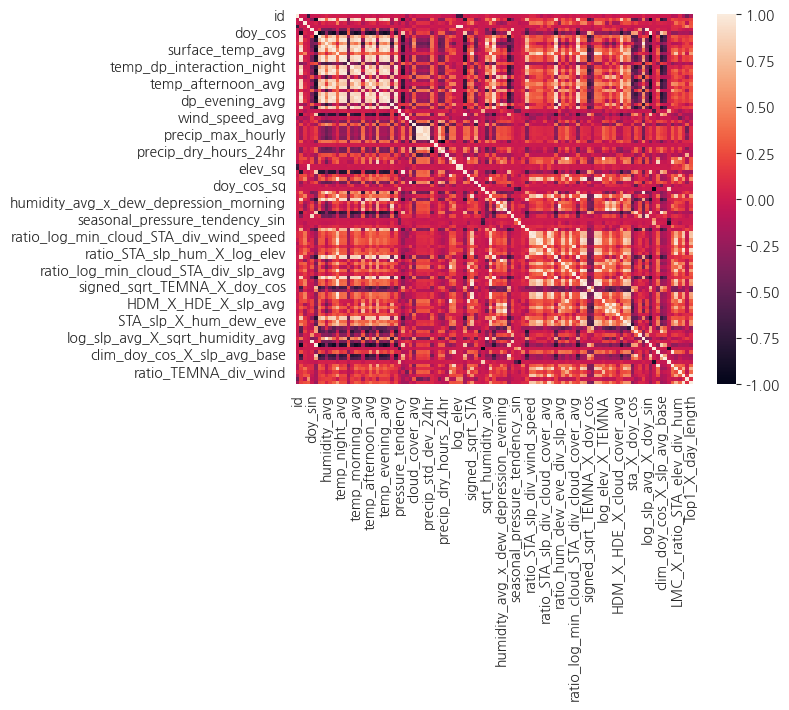

In [427]:
corr = train_df.corr()
sns.heatmap(corr)

> Export

In [428]:
# export df
train_df.to_csv("./input/processed/train_df_final_v5.csv", index=False)
test_df.to_csv("./input/processed/test_df_final_v5.csv", index=False)